## Kaggle Project

**Keith Faunce**

https://www.kaggle.com/competitions/predicting-car-prices-from-text-11-5-25/overview

<br>

# Predicting Car Prices from Seller Descriptions

This competition was designed to help people understand/predict the pricing for used vechiles. With hundreds of different vechiles on the market, and tens of brands, if cars aren't your fortee, how do you know what a fair price may be? There are two datasets provided, train & test. Train contains the **vehicle_id**, an **unstructured description of the car**, and **price**. Testing contains **vehicle_id** and **unstructured descriptions.** My goal is to provide predictions as to what a vehicle should be priced at based on the description.

In [41]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import Ridge
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_absolute_error

In [2]:
train = pd.read_csv(r'kaggle_proj/train_text.csv')
test = pd.read_csv(r'kaggle_proj/test_text.csv')

## Visualizations & Pre-processing

In [3]:
train.head(3)

,id,description,price
0,42508,Title status: Yes. Running on Gasoline with a ...,64000
1,43045,Clean title: Yes. Gray exterior with Black int...,145000
2,34855,Available in ATLANTA: This meticulously mainta...,6995


In [4]:
test.head(3)

,id,description
0,39977,Located in Denver - For sale: Mercedes-Benz AM...
1,47881,"Regarding vehicle history, accident status: No..."
2,288,Available in Dallas: This meticulously maintai...


In [5]:
print(f"The shape of the training dataset: {train.shape}. The shape of the testing dataset: {test.shape}")

The shape of the training dataset: (27136, 3). The shape of the testing dataset: (27137, 2)


In [6]:
train["price"].describe().apply(lambda x: f"{x:.2f}")

count      27136.00
mean       39396.98
std        72688.89
min         2000.00
25%        15900.00
50%        28000.00
75%        45573.75
max      2954083.00
Name: price, dtype: object

The vehicle that is listed at almost $3 million is a 2005 Hummer, attributes like these will be removed. However, vehicles with poor or "weak" descriptions will not be removed. Hoping that all vehicle listings will be as informative as the next is overly optimistic, and it is natural to account for vehicles with poor descriptions.

Text(0, 0.5, 'Price')

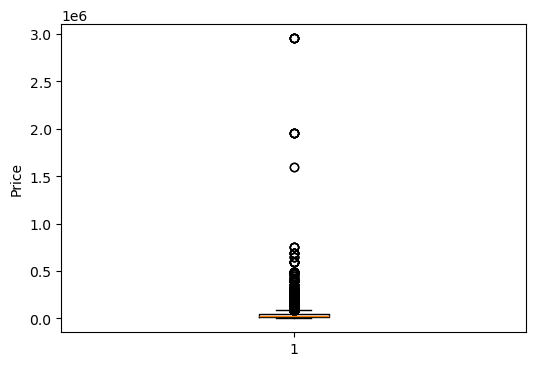

In [7]:
plt.figure(figsize=(6,4))
plt.boxplot(train["price"], vert=True)
plt.ylabel("Price")

In [8]:
# Getting IQR to remove price inconsistencies
Q1 = train["price"].quantile(0.25)
Q3 = train["price"].quantile(0.75)
IQR = Q3 - Q1
print(f"25th Percentile: {Q1}")
print(f"75th Percentile: {Q3}")
print(f"IQR: {IQR}")

25th Percentile: 15900.0
75th Percentile: 45573.75
IQR: 29673.75


In [9]:
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
train_clean = train[(train["price"] >= lower_bound) & (train["price"] <= upper_bound)]

In [10]:
# About 1500 records were removed
train_clean.shape

(25657, 3)

Text(0, 0.5, 'Price')

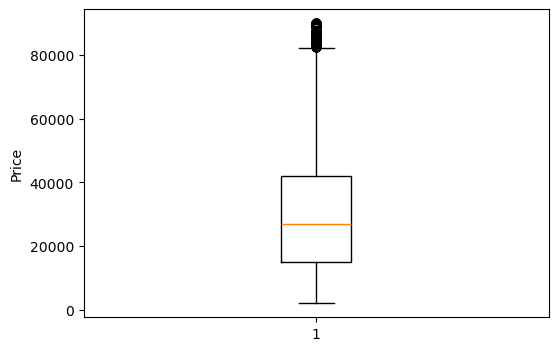

In [11]:
plt.figure(figsize=(6,4))
plt.boxplot(train_clean["price"], vert=True)
plt.ylabel("Price")

Removing normalizied outliers. No lower outliers were removed (Same shape dropping only upper)

In [16]:
log_p = np.log1p(train["price"])
Q3 = log_p.quantile(0.75)
Q1 = log_p.quantile(0.25)
IQR = Q3 - Q1
upper = Q3 + 1.5 * IQR

In [17]:
mask = log_p <= upper
train_log = train[mask]

In [19]:
train_log.shape

(26850, 3)

Text(0, 0.5, 'Price')

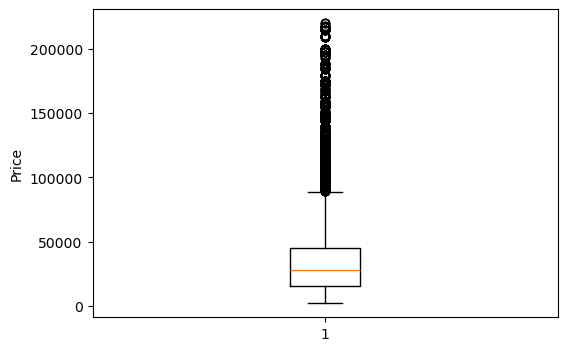

In [20]:
plt.figure(figsize=(6,4))
plt.boxplot(train_log["price"], vert=True)
plt.ylabel("Price")

I'm going to use this training set going forward, there are a multitude of luxury vehicles that were being unfairly removed. Dataset contains many luxury German imports.

<br>

## Model

In [21]:
X = train_log["description"]
y = train_log["price"]

In [25]:
model = Pipeline([("tfidf", TfidfVectorizer(
    max_features=30000,
    ngram_range=(1,2),
    min_df=3,
    stop_words="english")),
    ("ridge", Ridge(alpha=1.0))
])

In [26]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [27]:
model.fit(X_train, y_train)

,steps,"[('tfidf', ...), ('ridge', ...)]"
,transform_input,None
,memory,None
,verbose,False
,input,'content'
,encoding,'utf-8'
,decode_error,'strict'
,strip_accents,None
,lowercase,True
,preprocessor,None
,tokenizer,None


In [28]:
print("Validation R2:", model.score(X_val, y_val))

Validation R2: 0.5056209021736443


In [29]:
model.fit(X, y)

,steps,"[('tfidf', ...), ('ridge', ...)]"
,transform_input,None
,memory,None
,verbose,False
,input,'content'
,encoding,'utf-8'
,decode_error,'strict'
,strip_accents,None
,lowercase,True
,preprocessor,None
,tokenizer,None


## Metrics

In [40]:
print("R2:", model.score(X, y))

R2: 0.6276770322252434


In [42]:
mae_pred = model.predict(X_val)
mae = mean_absolute_error(y_val, mae_pred)
print(f"Mean Absolute Error: {mae}")

Mean Absolute Error: 10466.32701957545


Based on the data within the dataset and the MAE, we can determine that the model understands cars are expensive, but it doesn't exaclty pinpoint how expensive. For example, in the output below a used Mazda CX-5 is priced at 37,500 USD. While the model does have upgrades, the base price for a new CX-5 is 28,500 USD. This case can also be seen with the 2008 Ford Taurus housing 150,000 miles, where it is priced at over $13,000 USD.

The only submission on Kaggle has a MAE or 16,000. I'm assuming they didn't filter for outliers and or normalizied outliers.

In [30]:
predictions = model.predict(test["description"])

In [35]:
preds = pd.DataFrame({"vehicle_id": test.id, "description": test.description, "price": predictions})

In [38]:
pd.set_option('display.max_colwidth', None)

In [39]:
preds.head(20)

,vehicle_id,description,price
0,39977,"Located in Denver - For sale: Mercedes-Benz AMG G 63 Base with clean title status: Yes. Model year: 2017, 67,000 mi on odometer. Features White exterior, Black interior, 8-Speed A/T transmission. Powered by Gasoline 563.0HP 5.5L 8 Cylinder Engine Gasoline Fuel. Accident history: None reported.",59149.931368
1,47881,"Regarding vehicle history, accident status: None reported. Title verification: Yes. Presenting an exceptional opportunity to own a remarkable 2022 Jeep Gladiator Rubicon in pristine condition. The sophisticated A/T transmission provides seamless gear transitions for optimal driving dynamics. Powered by Gasoline and featuring the impressive 285.0HP 3.6L V6 Cylinder Engine Gasoline Fuel that delivers both power and efficiency. This desirable automobile awaits your inspection in sanfran. The odometer currently displays a well-documented 3,000 miles. The vehicle boasts an eye-catching White exterior finish that turns heads wherever it goes, while the immaculate Black interior offers supreme comfort and contemporary styling.",50095.823054
2,288,"Available in Dallas: This meticulously maintained 2013 Mercedes-Benz SL-Class SL 550 with title status Yes. The exterior is finished in stunning White, perfectly complemented by a luxurious Beige interior that exudes comfort and style. Has been driven just 115,000 miles and operates efficiently on Gasoline fuel, showcasing its reliable 429.0HP 4.6L 8 Cylinder Engine Gasoline Fuel for impressive performance. Equipped with a smooth-shifting Transmission w/Dual Shift Mode transmission for an exceptional driving experience. Previous accident history: At least 1 accident or damage reported. This exceptional vehicle is currently available for viewing and test drives.",27531.843491
3,31330,"Located in San Jose - For sale: Cadillac Escalade ESV Luxury with clean title status: Yes. Model year: 2019, 26,000 mi on odometer. Features Silver exterior, Black interior, 10-Speed A/T transmission. Powered by Gasoline 420.0HP 6.2L 8 Cylinder Engine Gasoline Fuel. Accident history: None reported.",58934.153369
4,31387,"Title status: Yes. Running on Gasoline with a 181.0HP 1.6L 4 Cylinder Engine Gasoline Fuel, this 2012 MINI Cooper S Base is available in Dallas. Features 6-Speed A/T transmission and has 91,700 miles. Interior cabin: Black, exterior paint: Blue. Accident history: None reported.",7988.331644
5,46908,"Available in Seattle: This meticulously maintained 2019 RAM ProMaster 2500 High Roof with title status Yes. The exterior is finished in stunning White, perfectly complemented by a luxurious Black interior that exudes comfort and style. Has been driven just 8,044 miles and operates efficiently on Gasoline fuel, showcasing its reliable 280.0HP 3.6L V6 Cylinder Engine Gasoline Fuel for impressive performance. Equipped with a smooth-shifting 6-Speed A/T transmission for an exceptional driving experience. Previous accident history: None reported. This exceptional vehicle is currently available for viewing and test drives.",44177.961779
6,3492,"Available in Chicago: This meticulously maintained 2014 BMW 328 i with title status Yes. The exterior is finished in stunning White, perfectly complemented by a luxurious Beige interior that exudes comfort and style. Has been driven just 83,298 miles and operates efficiently on Gasoline fuel, showcasing its reliable 240.0HP 2.0L 4 Cylinder Engine Gasoline Fuel for impressive performance. Equipped with a smooth-shifting 8-Speed A/T transmission for an exceptional driving experience. Previous accident history: At least 1 accident or damage reported. This exceptional vehicle is currently available for viewing and test drives.",14198.614890
7,10185,"Title status: Yes. Running on Diesel with a 188.0HP 3.0L V6 Cylinder Engine Diesel Fuel, this 2021 Mercedes-Benz Sprinter 3500 High Roof is available in New York. Features A/T transmission and has 124,630 miles. Interior cabin: Black, exterior paint: Black. Accident history